In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import seaborn as sns
import pickle
#import descartes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Loading the accident data of Seattle city

df = gpd.read_file('https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.geojson')


In [23]:
df.shape

(207450, 39)

In [24]:
df.columns

Index(['OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE',
       'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE',
       'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES',
       'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'geometry'],
      dtype='object')

In [25]:
df.head(3)

,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,...,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,geometry
0,1,278937,279837,3694471,Matched,Intersection,25692.0,GREEN LAKE WAY N AND N 46TH ST,,None,...,Daylight,None,None,None,10,Entering at angle,0,0,N,POINT (-122.3460888005784 47.66212734235389)
1,2,278562,279462,3754273,Matched,Block,NaN,LAKE CITY WAY NE BETWEEN NE 125TH ST AND NE 12...,,None,...,Dark - Street Lights On,None,None,None,50,Fixed object,0,0,N,POINT (-122.2946976625274 47.72018380343322)
2,3,278997,279897,E782796,Matched,Block,NaN,1ST AVE NE BETWEEN NE 50TH ST AND NE 51ST ST,NEI,"Not Enough Information, or Insufficient Locati...",...,Daylight,None,None,None,32,One parked--one moving,0,0,Y,POINT (-122.3282834315786 47.66536715952205)


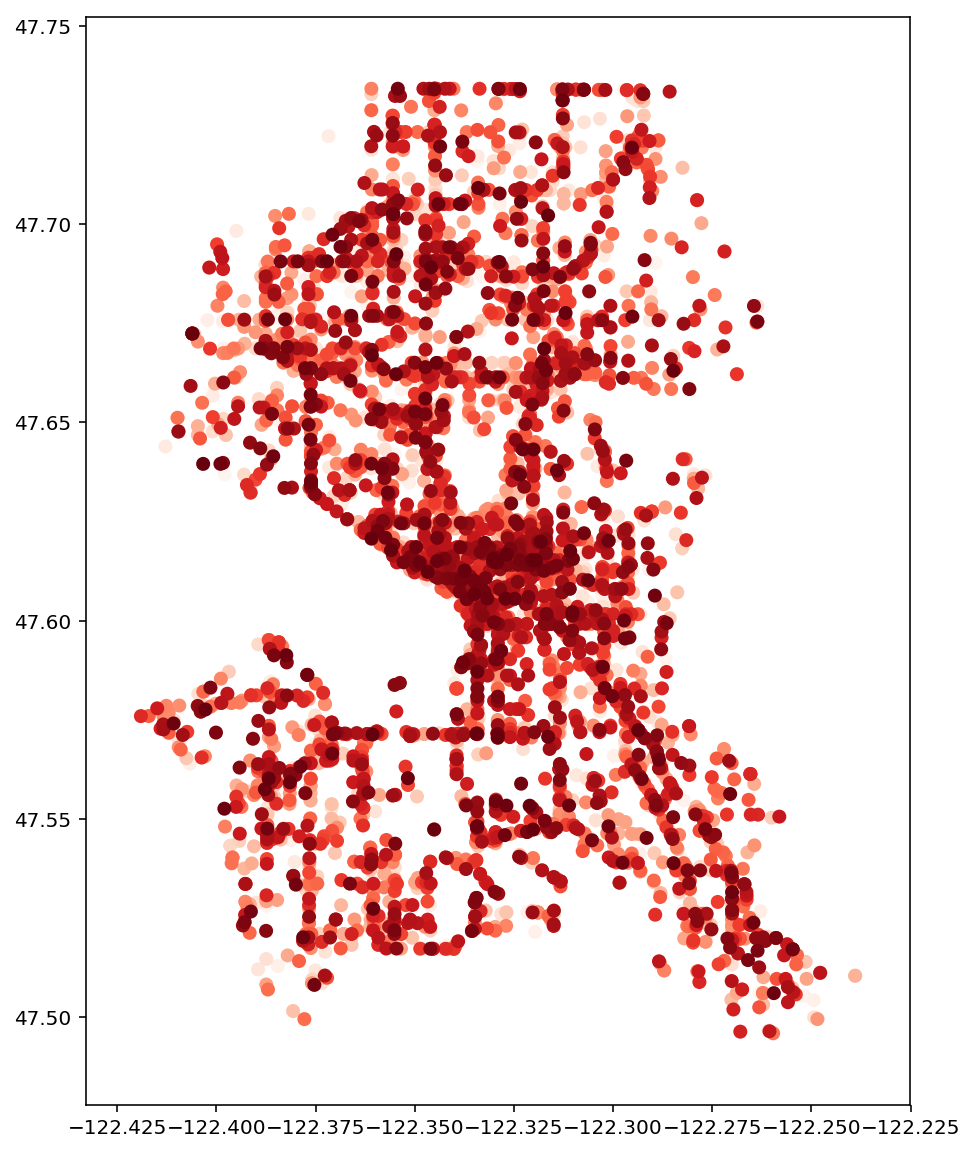

In [10]:
df[df['UNDERINFL'] == 'Y'].plot(cmap = 'Reds', figsize = (12, 10))

In [26]:
df['INCDATE'].unique()

array(['2018-03-26T00:00:00', '2018-03-23T00:00:00',
       '2018-03-24T00:00:00', ..., '2018-07-15T00:00:00',
       '2018-07-03T00:00:00', '2017-10-26T00:00:00'], dtype=object)

In [27]:
df['INTKEY'].unique()

array([ 25692.,     nan,  34470., ...,  24131., 613103.,  24603.])

In [13]:
df['JUNCTIONTYPE'].unique()

array(['At Intersection (intersection related)',
       'Mid-Block (not related to intersection)', None,
       'Mid-Block (but intersection related)', 'Driveway Junction',
       'Unknown', 'At Intersection (but not related to intersection)',
       'Ramp Junction'], dtype=object)

In [28]:
# Extracting the possible features that will be used in the model
new_df = df[['OBJECTID','ADDRTYPE', 'LOCATION','SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT',
'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES',
'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'UNDERINFL', 'WEATHER', 'ROADCOND',
'LIGHTCOND', 'HITPARKEDCAR','geometry']]

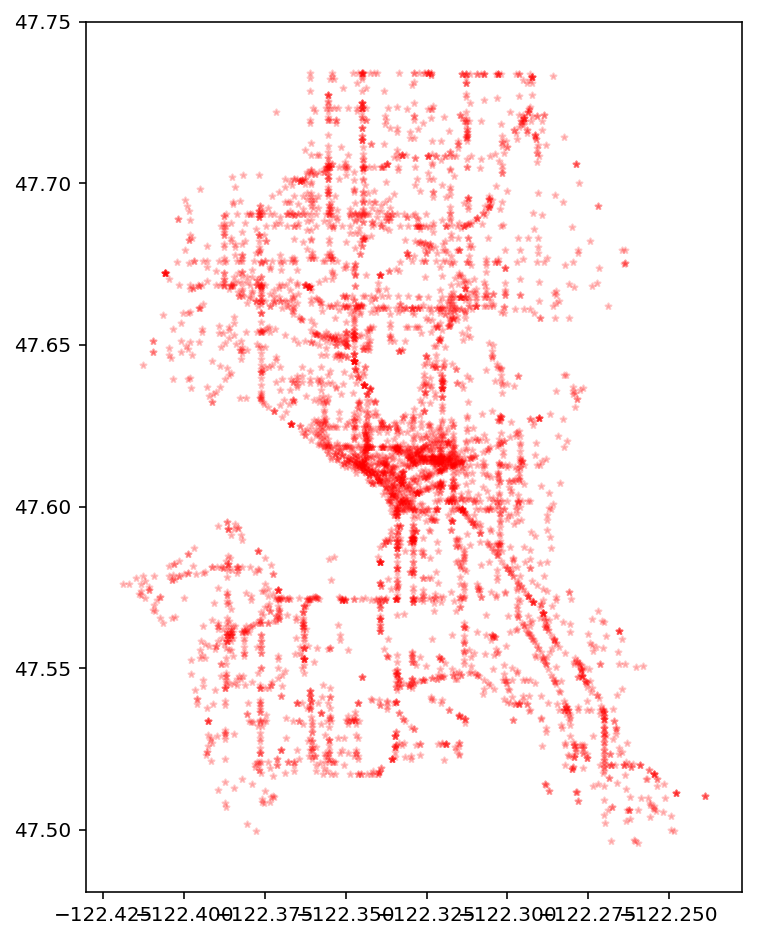

In [29]:
new_df[new_df['UNDERINFL']=='Y'].plot(figsize = (12,8), marker = '*', markersize = 10, facecolor = 'red',alpha = 0.2)

In [30]:
new_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 207450 entries, 0 to 207449
Data columns (total 22 columns):
OBJECTID           207450 non-null int64
ADDRTYPE           203828 non-null object
LOCATION           203009 non-null object
SEVERITYCODE       207449 non-null object
SEVERITYDESC       207450 non-null object
COLLISIONTYPE      183003 non-null object
PERSONCOUNT        207450 non-null int64
PEDCOUNT           207450 non-null int64
PEDCYLCOUNT        207450 non-null int64
VEHCOUNT           207450 non-null int64
INJURIES           207450 non-null int64
SERIOUSINJURIES    207450 non-null int64
FATALITIES         207450 non-null int64
INCDATE            207450 non-null object
INCDTTM            207450 non-null object
JUNCTIONTYPE       196327 non-null object
UNDERINFL          183024 non-null object
WEATHER            182850 non-null object
ROADCOND           182907 non-null object
LIGHTCOND          182758 non-null object
HITPARKEDCAR       207450 non-null object
geometr

In [31]:
new_df.isna().sum()

OBJECTID               0
ADDRTYPE            3622
LOCATION            4441
SEVERITYCODE           1
SEVERITYDESC           0
COLLISIONTYPE      24447
PERSONCOUNT            0
PEDCOUNT               0
PEDCYLCOUNT            0
VEHCOUNT               0
INJURIES               0
SERIOUSINJURIES        0
FATALITIES             0
INCDATE                0
INCDTTM                0
JUNCTIONTYPE       11123
UNDERINFL          24426
WEATHER            24600
ROADCOND           24543
LIGHTCOND          24692
HITPARKEDCAR           0
geometry            7267
dtype: int64

In [34]:
# Converting INCDATE AND INCDTTM to pandas date time columns
new_df.loc[:, 'datetime'] = pd.to_datetime(new_df['INCDATE'])
new_df.loc[:, 'time'] = pd.to_datetime(new_df['INCDTTM'])

In [39]:
new_df.tail()

,OBJECTID,ADDRTYPE,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,LIGHTCOND,HITPARKEDCAR,geometry,datetime,time,year,month,day,dayofweek,hour
207445,206996,Block,CHERRY ST BETWEEN 9TH AVE AND TERRY AVE,0,Unknown,None,0,0,0,0,...,None,Y,POINT (-122.3248498581322 47.60650008306229),2017-11-01,2017-11-01 00:00:00,2017,11,1,2,0
207446,206997,Block,DEXTER AVE N BETWEEN HAYES ST AND HOWE ST,0,Unknown,None,0,0,0,0,...,None,Y,POINT (-122.3422851798906 47.63498698711708),2017-11-02,2017-11-02 00:00:00,2017,11,2,3,0
207447,206998,Intersection,SWIFT AVE S AND S ALBRO PL,0,Unknown,None,0,0,0,0,...,None,N,POINT (-122.3111306348675 47.54888558774338),2017-11-01,2017-11-01 00:00:00,2017,11,1,2,0
207448,206999,Intersection,10TH AVE AND E PINE ST,1,Property Damage Only Collision,Pedestrian,2,1,0,1,...,Dark - Street Lights On,N,POINT (-122.319465475531 47.61524513736841),2017-11-08,2017-11-08 22:01:00,2017,11,8,2,22
207449,207000,Block,FAUNTLEROY WAY SW BETWEEN WEST SEATTLE BR EB A...,0,Unknown,None,0,0,0,0,...,None,Y,POINT (-122.3765414498836 47.56486552243014),2017-10-30,2017-10-30 00:00:00,2017,10,30,0,0


In [36]:
# Creating year, month, day, and dayofweek columns
new_df.loc[:,'year'] = pd.DatetimeIndex(new_df['datetime']).year
new_df.loc[:,'month'] = pd.DatetimeIndex(new_df['datetime']).month
new_df.loc[:,'day'] = pd.DatetimeIndex(new_df['datetime']).day
new_df.loc[:,'dayofweek'] = pd.DatetimeIndex(new_df['datetime']).dayofweek

In [37]:
#new_df['year'] = pd.DatetimeIndex(new_df['datetime']).year
new_df.loc[:,'hour'] = pd.DatetimeIndex(new_df['time']).hour

In [38]:
new_df.shape

(207450, 29)

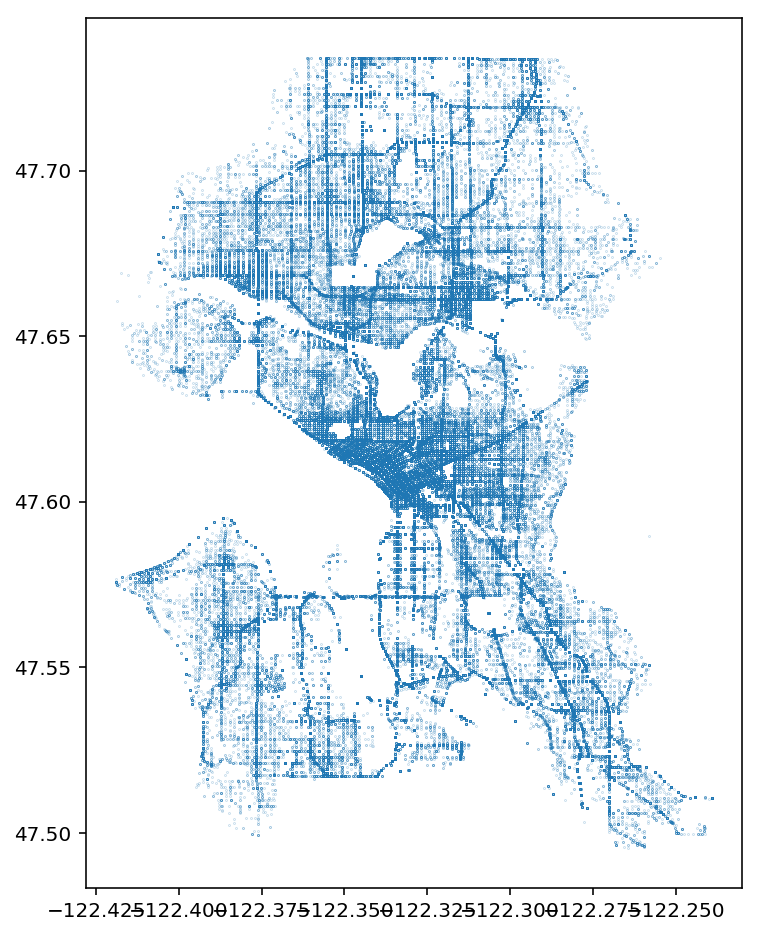

In [28]:
# Accident plot of Seattle city from 2004 to 2019
fig, ax = plt.subplots(figsize=(14, 8))
new_df.plot(ax = ax, markersize = 0.01)

In [73]:
# Coordinate reference system to use geopandas dataframe
# crs = {'init': 'epsg:4326'}

In [72]:
# how to make a Point column (of shapely) in pandas dataframe 
# geometry = [Point(xy) for xy in zip(new_df['X'], new_df['Y'])]

In [74]:
# Creating a new column geometry in pandas dataframe
# geo_df = gpd.GeoDataFrame(new_df, crs = crs, geometry = geometry)


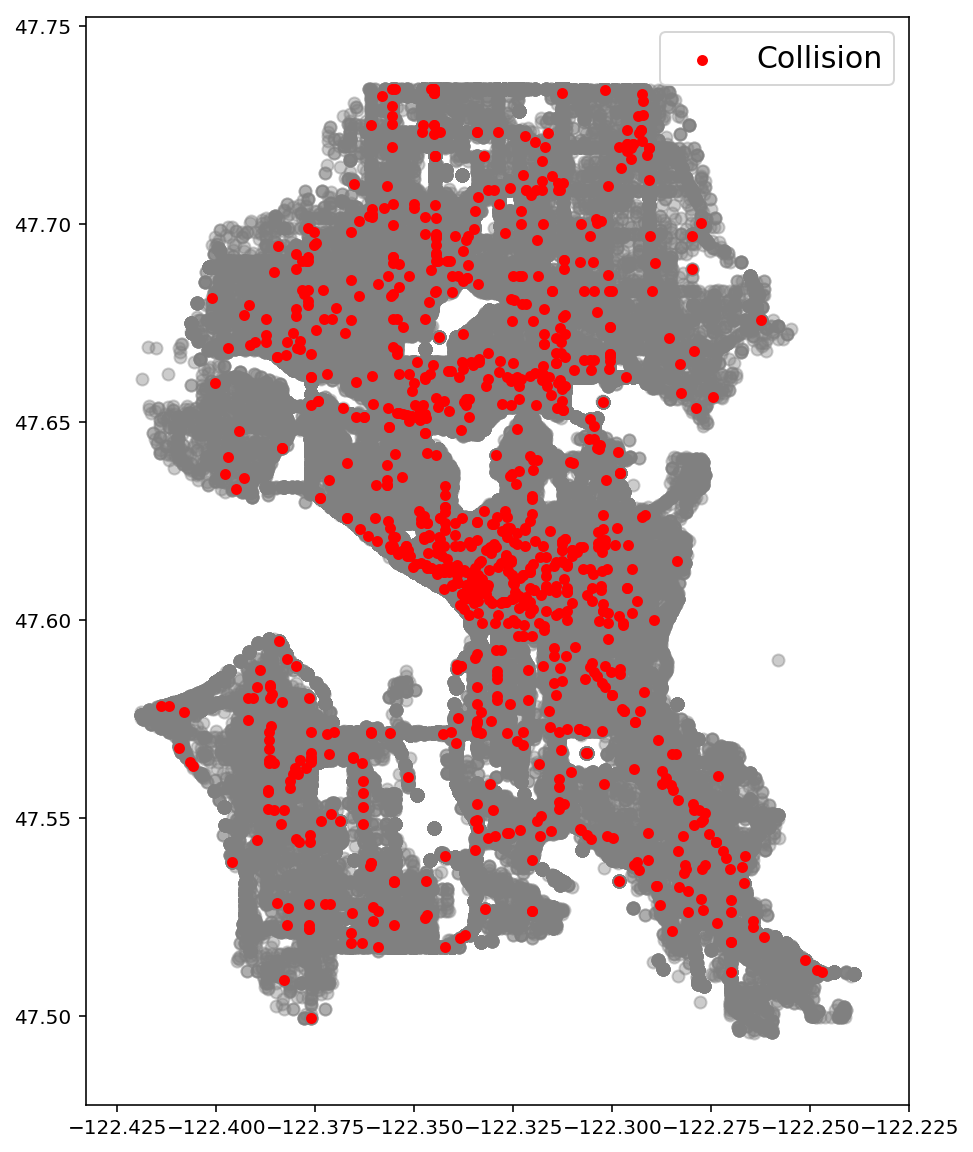

In [29]:
# An example of the plot of some accidents 1000 on the shapefile of Seattle map

fig, ax = plt.subplots(figsize = (12, 10))
new_df.plot(ax = ax, alpha = 0.4, color = 'grey')
new_df[:1000].plot(ax = ax, markersize =20, color = 'red', marker = 'o', label = 'Collision')
plt.legend(prop = {'size':15})

Text(0.5, 1.0, '2016 New Years Eve')

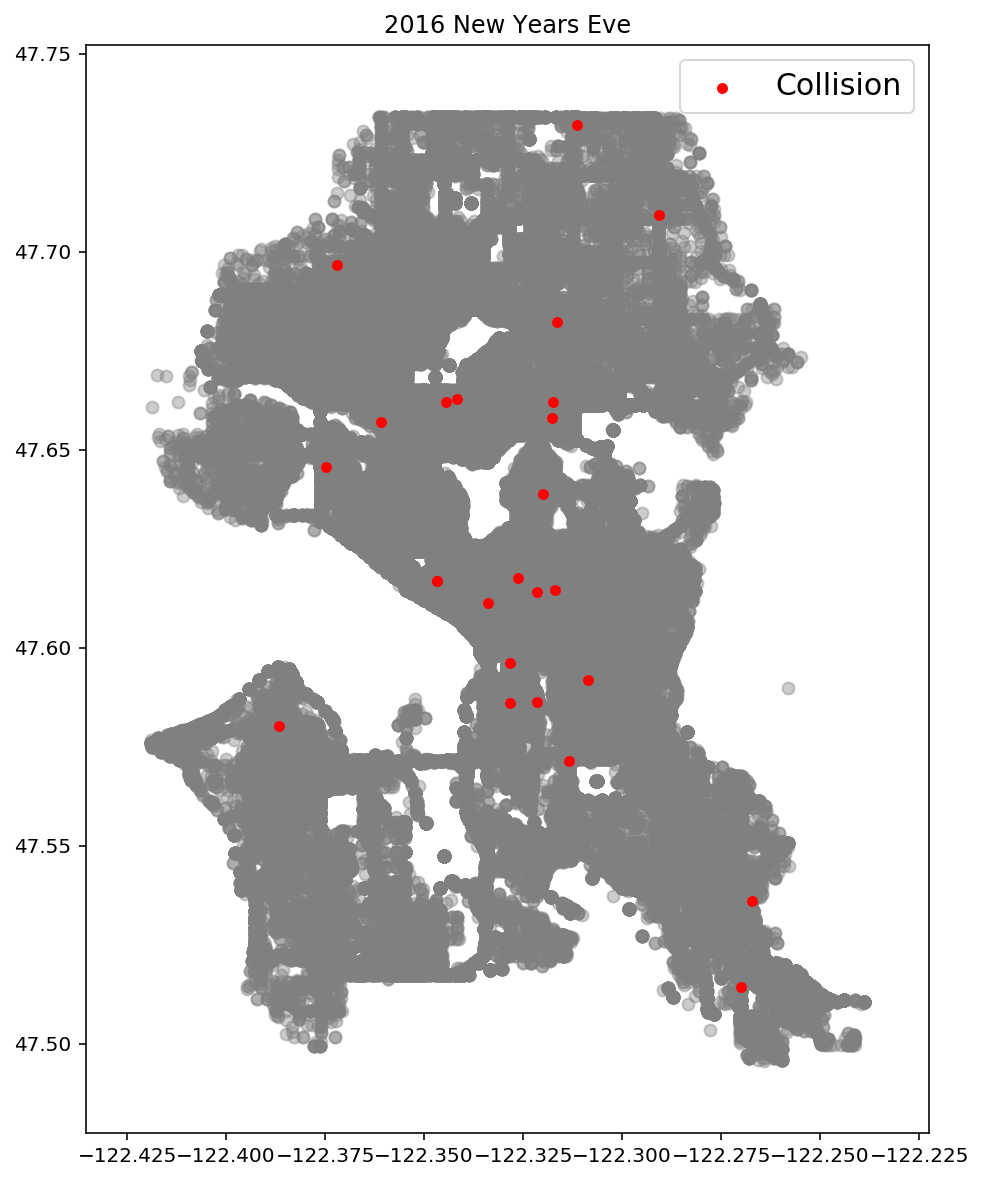

In [70]:
# accident points on New Year's Eve in 2015

fig, ax = plt.subplots(figsize = (8, 10))
new_df.plot(ax = ax, alpha = 0.4, color = 'grey')
new_df[(new_df['year']== 2016) & (new_df['month'] == 12) & (new_df['day']==31)].plot(ax = ax, markersize =20, color = 'red', marker = 'o', label = 'Collision')
plt.legend(prop = {'size':15})
plt.title('2016 New Years Eve')

In [31]:
# number of accidents on New Year's Eve in 2018

new_df[(new_df['year']== 2018) & (new_df['month'] == 12) & (new_df['day']==31)].shape[0]

38

Text(0, 0.5, 'Number of accidents')

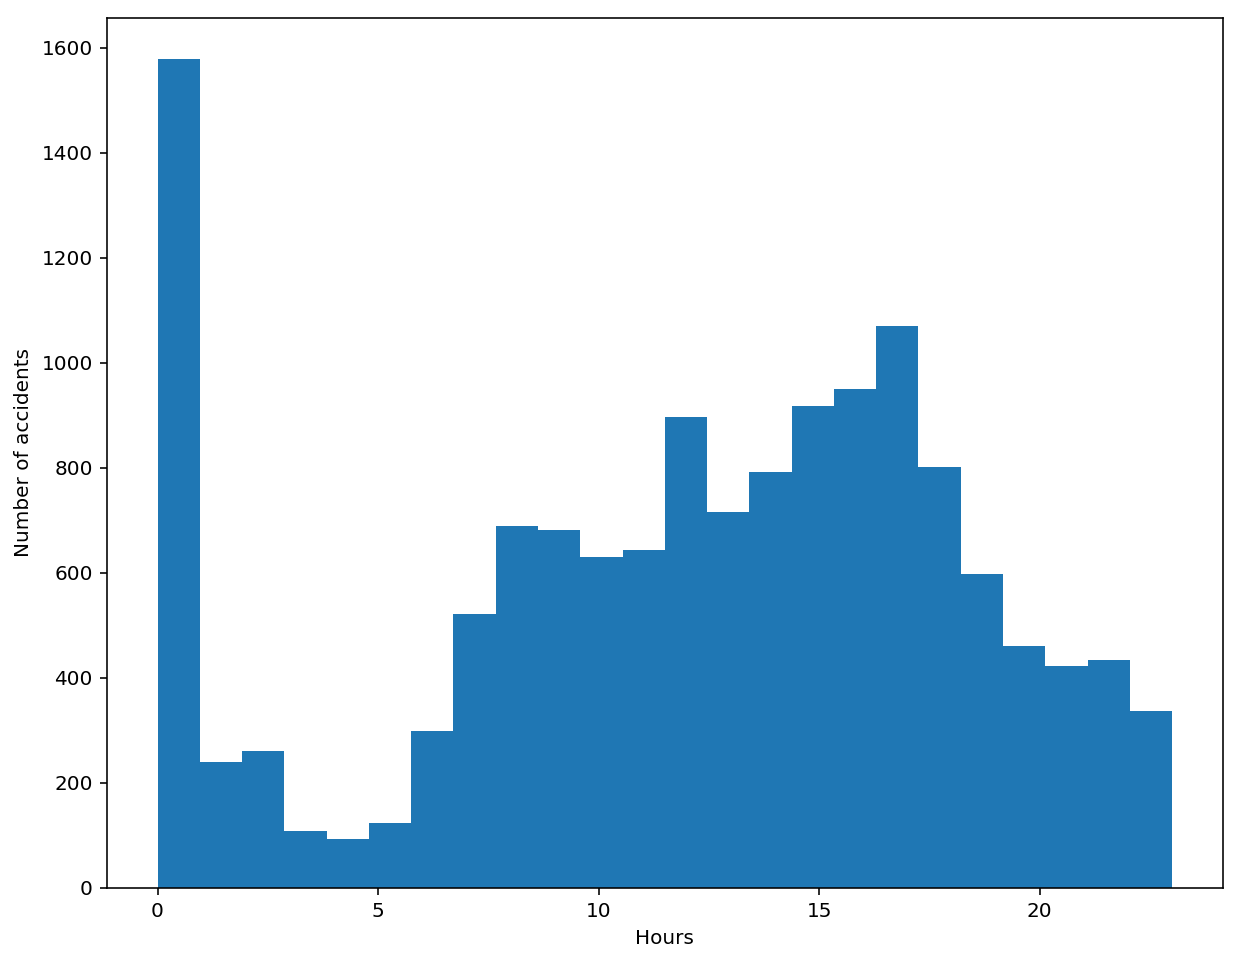

In [32]:
# histogram example of hourly number of accidents in 2015

plt.figure(figsize=(10, 8))
plt.hist(new_df[new_df['year'] == 2015]['hour'], bins = 24)
plt.xlabel('Hours')
plt.ylabel('Number of accidents')

(array([1943.,    0., 2112.,    0., 2100.,    0., 2286.,    0., 2188.,
           0., 2002., 1629.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <a list of 12 Patch objects>)

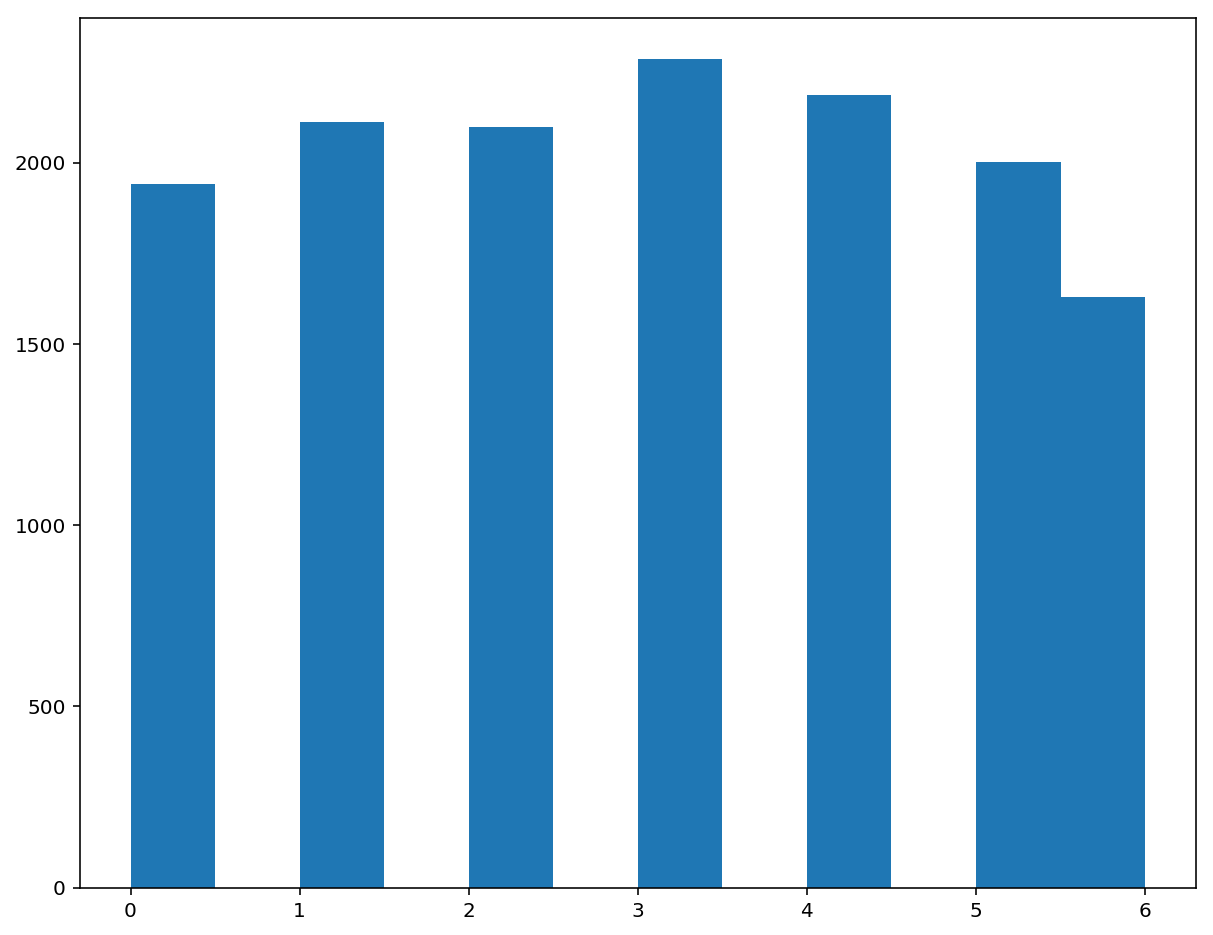

In [33]:
# histogram example of weekly number of accidents in 2015
plt.figure(figsize=(10, 8))
plt.hist(new_df[new_df['year'] == 2015]['dayofweek'], bins = 12)

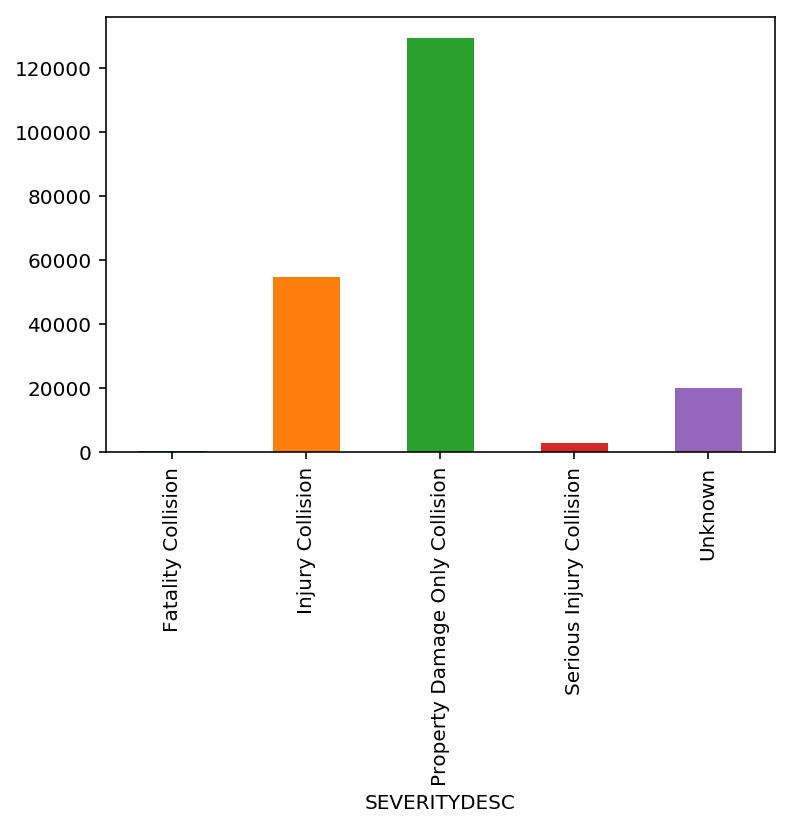

In [34]:
# Some bar plots 

#acc_count = acc.groupby(acc.Accident_Severity).Accident_Severity.count().plot(kind = 'bar')
new_df.groupby(new_df['SEVERITYDESC']).SEVERITYDESC.count().plot(kind = 'bar')

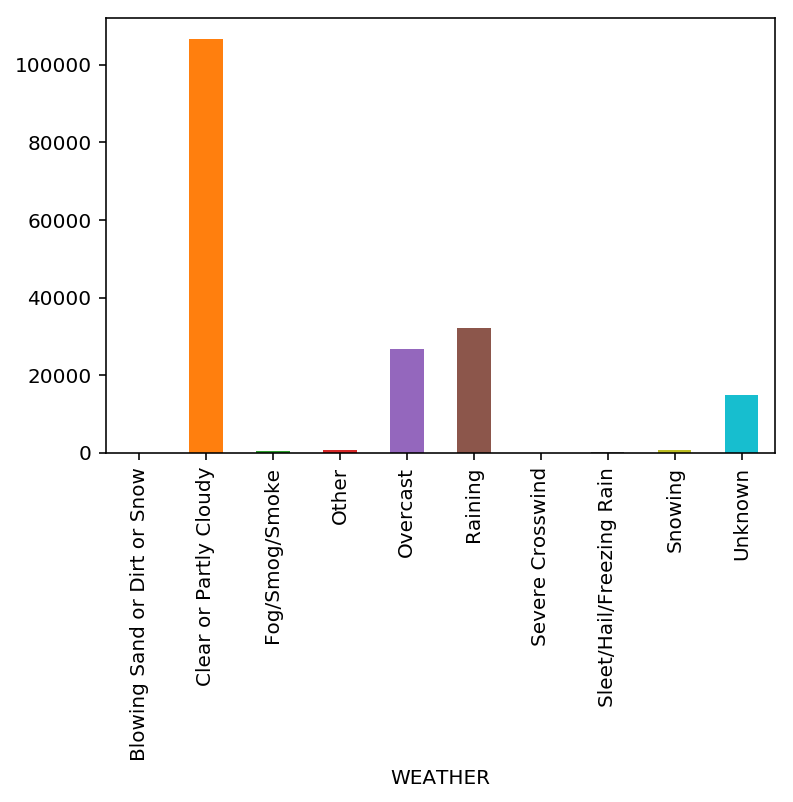

In [35]:
new_df.groupby(new_df['WEATHER']).SEVERITYDESC.count().plot(kind = 'bar')

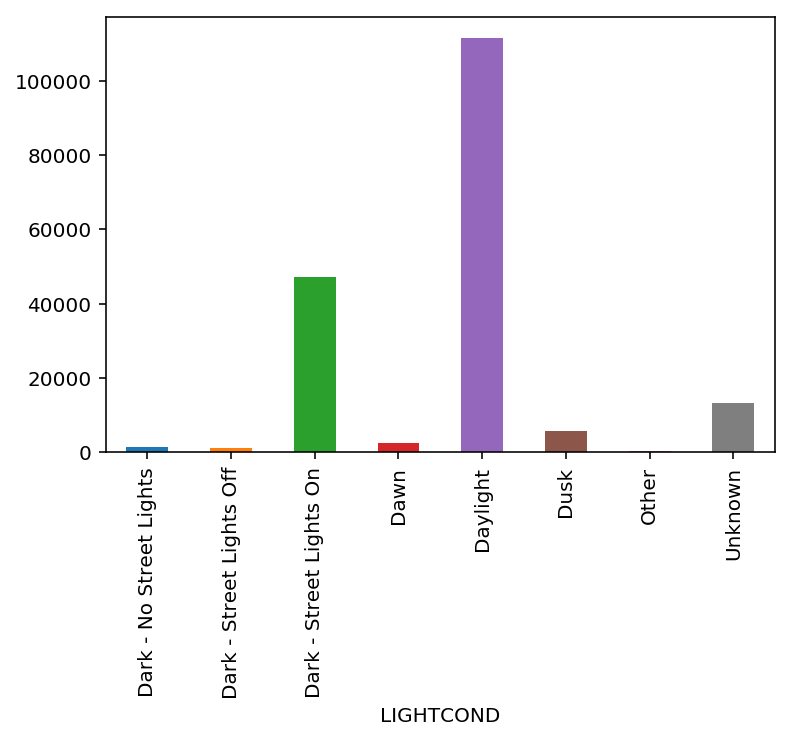

In [36]:
new_df.groupby(new_df['LIGHTCOND']).SEVERITYDESC.count().plot(kind = 'bar')

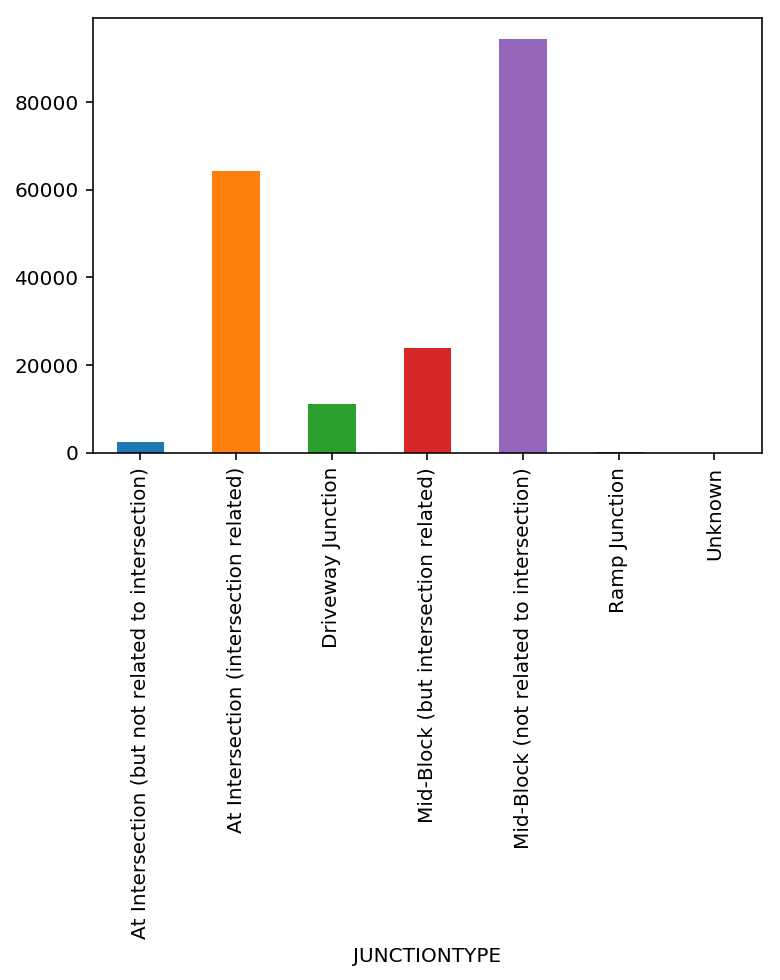

In [37]:
new_df.groupby(new_df['JUNCTIONTYPE']).SEVERITYDESC.count().plot(kind = 'bar')

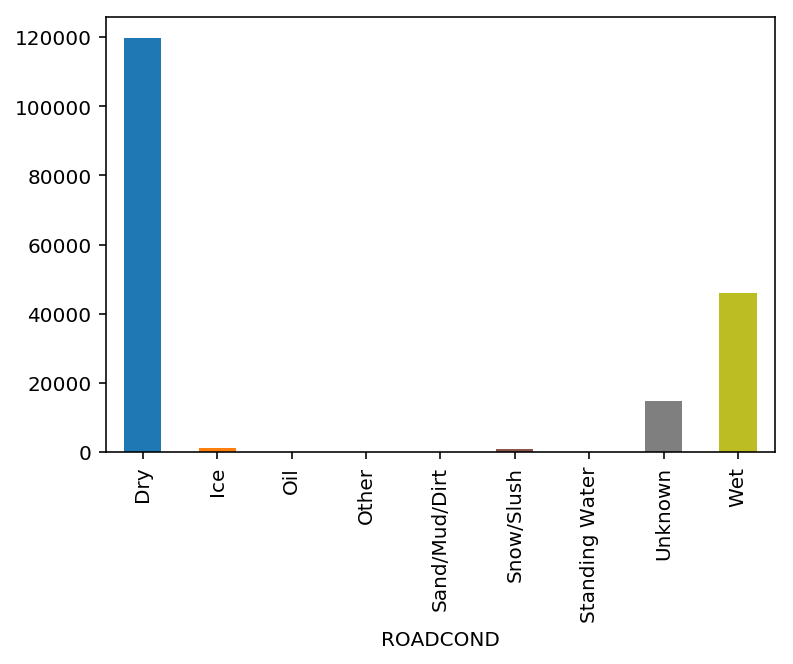

In [38]:
# bar plot of accidents by road conditions
new_df.groupby(new_df['ROADCOND']).SEVERITYDESC.count().plot(kind = 'bar')

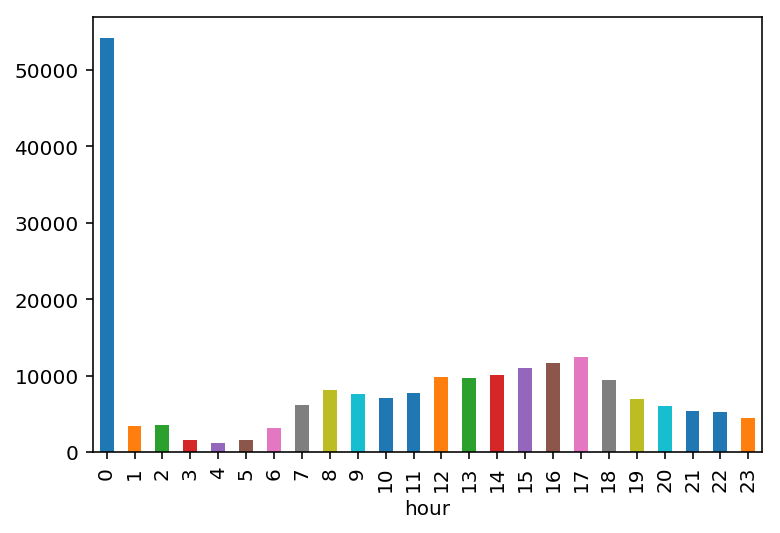

In [39]:
new_df.groupby(new_df['hour']).SEVERITYDESC.count().plot(kind = 'bar')

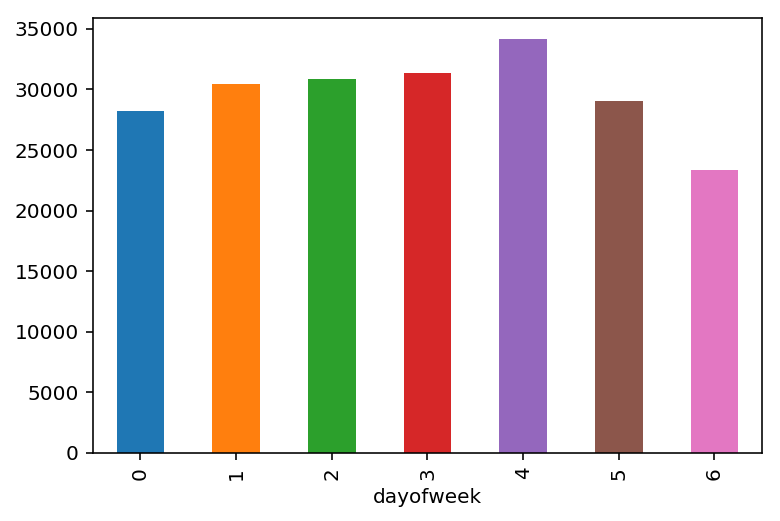

In [40]:
new_df.groupby(new_df['dayofweek']).SEVERITYDESC.count().plot(kind = 'bar')

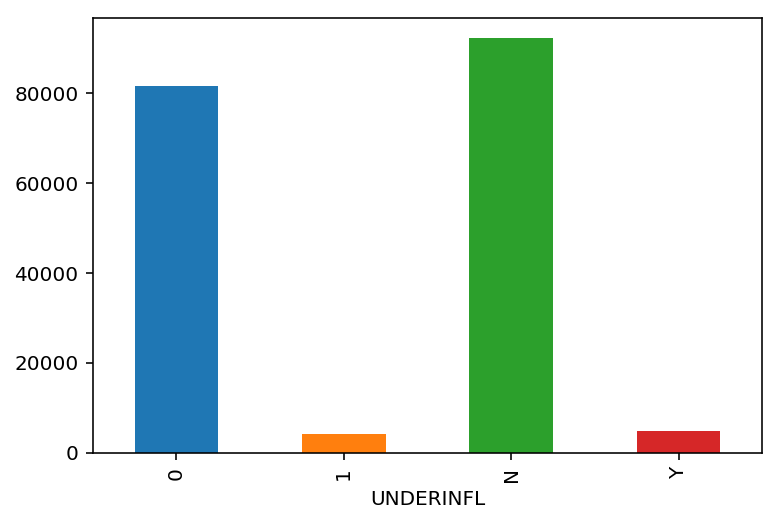

In [41]:
new_df.groupby(new_df['UNDERINFL']).SEVERITYDESC.count().plot(kind = 'bar')

# Loading the traffic flow map volumes of Seattle city.
# The most recent data for traffic volume data will be used in the model.

In [58]:
volume = gpd.read_file('https://opendata.arcgis.com/datasets/170b764c52f34c9497720c0463f3b58b_9.geojson')

In [59]:
volume.rename(columns = {'OBJECTID': 'SEGID'}, inplace=True)

,SEGID,COUNT_COMPKEY,FIRST_STNAME_ORD,FIRST_ARTDESCRIPT,FIRST_TRANDESCRIPT,COUNTFLAG,FLOWSEGID,DOWNTOWN,COUNTSTART,COUNTAADT,COUNTAAWDT,ESTIMATE,AWDT_ROUND,SHAPE_Length,geometry
0,1,None,S SPOKANE ST,None,None,Y,2019.0,N,2015-04-03T00:00:00,5508.833000,6829.504000,None,6800.0,1118.471355,LINESTRING (-122.3396800681195 47.571700326672...
1,2,None,BATTERY ST TUNNEL NB,None,None,Y,2023.0,N,2015-06-09T00:00:00,27080.835000,28793.392000,None,28800.0,1605.935119,LINESTRING (-122.3392266031084 47.570739990412...
2,3,None,ALASKAN WY VI SB,None,None,Y,2024.0,N,2015-06-09T00:00:00,0.000000,23393.664000,None,23400.0,2441.189454,LINESTRING (-122.3394359390524 47.566345148425...
3,4,None,S SPOKANE ST RP,None,None,Y,2025.0,N,2015-06-09T00:00:00,3622.684000,4421.927000,None,4400.0,1214.542393,LINESTRING (-122.3434333843779 47.571579040153...
4,5,None,WEST SEATTLE BR WB,None,None,Y,2026.0,N,2014-04-29T00:00:00,46875.085335,50036.029406,None,50000.0,1817.352489,LINESTRING (-122.333137393517 47.5715774100566...


# Now we start merging the traffic volume data to the accident data.

In [61]:
acc = new_df.copy()


In [62]:
acc = acc[acc.geometry.notnull()]

In [45]:
# getting the geometry data 
def get_geom(df):
    return df.geometry

In [46]:
# Getting the geometries of traffic accident data 

points = get_geom(acc)
segments = get_geom(volume)



In [147]:
# function to find the minimum distance between each accident point and traffic volume of road segments 
# in the traffic volume data

def min_dist(points, linestrings):
    
    dist = []
    for i in points:
        dis = []
        for j in linestrings:
            dis.append(j.distance(i))
        
        dist.append(np.array(dis).argmin())
    
    return np.array(dist)


In [3]:
# the code below extracts the indices of traffic volume data that correspond to the closest distance to the accident points

# min_dist_idx = min_dist(points, segments)

In [63]:
indices = pd.read_csv('min_dist_indices.csv', header = None).values
indices = indices.flatten()


In [123]:
# volume[['FIRST_STNAME_ORD', 'AWDT_ROUND', 'DOWNTOWN']].iloc[indices]

In [68]:
# indices = min_dist_idx.copy()

In [144]:
# saving the indices into a csv file

np.savetxt('min_dist_indices.csv', indices, fmt="%d", delimiter=",")


In [64]:
# We slice annual average daily traffic counts and name of the road segment into a new dataframe
# and set the indices the same as the traffic accident indices

aadt = volume[['FIRST_STNAME_ORD', 'AWDT_ROUND', 'DOWNTOWN', 'SEGID']].iloc[indices]

# Getting traffic accident data indices and setting them as the indices of aadt 

aadt['index'] = acc.index
aadt.set_index('index', inplace = True)

In [65]:
aadt.head()

,FIRST_STNAME_ORD,AWDT_ROUND,DOWNTOWN,SEGID
index,,,,
0,NE 50TH ST,23700.0,N,519
1,NE 145TH ST,38000.0,N,96
2,NE 50TH ST,24600.0,N,518
3,25TH AVE NE,18000.0,N,467
4,NW 36TH ST,22600.0,N,615


In [66]:
# Joining the traffic accident data with the traffic volume data

accident = acc.join(aadt)
# accident.to_pickle('acc_final.pickle')

In [67]:
accident.head()

,OBJECTID,ADDRTYPE,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,...,time,year,month,day,dayofweek,hour,FIRST_STNAME_ORD,AWDT_ROUND,DOWNTOWN,SEGID
0,1,Intersection,GREEN LAKE WAY N AND N 46TH ST,1,Property Damage Only Collision,Angles,2,0,0,2,...,2018-03-26 12:50:00,2018,3,26,0,12,NE 50TH ST,23700.0,N,519
1,2,Block,LAKE CITY WAY NE BETWEEN NE 125TH ST AND NE 12...,1,Property Damage Only Collision,Other,1,0,0,1,...,2018-03-23 03:30:00,2018,3,23,4,3,NE 145TH ST,38000.0,N,96
2,3,Block,1ST AVE NE BETWEEN NE 50TH ST AND NE 51ST ST,1,Property Damage Only Collision,Parked Car,2,0,0,2,...,2018-03-24 15:00:00,2018,3,24,5,15,NE 50TH ST,24600.0,N,518
3,4,Block,25TH AVE NE BETWEEN NE BLAKELEY ST AND NE 54TH ST,1,Property Damage Only Collision,Parked Car,2,0,0,2,...,2018-03-22 17:14:00,2018,3,22,3,17,25TH AVE NE,18000.0,N,467
4,5,Block,N 36TH ST BETWEEN PHINNEY AVE N AND FRANCIS AVE N,1,Property Damage Only Collision,Parked Car,2,0,0,2,...,2018-03-25 02:03:00,2018,3,25,6,2,NW 36TH ST,22600.0,N,615


In [68]:
# writing the final accident dataframe into a csv file or pickle 

# accident.to_csv('data/accident.csv', index = False)

accident.to_pickle('data/accident.pickle')

In [136]:
accident.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 200183 entries, 0 to 207449
Data columns (total 32 columns):
OBJECTID            200183 non-null int64
ADDRTYPE            200183 non-null object
LOCATION            200183 non-null object
SEVERITYCODE        200182 non-null object
SEVERITYDESC        200183 non-null object
COLLISIONTYPE       177878 non-null object
PERSONCOUNT         200183 non-null int64
PEDCOUNT            200183 non-null int64
PEDCYLCOUNT         200183 non-null int64
VEHCOUNT            200183 non-null int64
INJURIES            200183 non-null int64
SERIOUSINJURIES     200183 non-null int64
FATALITIES          200183 non-null int64
INCDATE             200183 non-null object
INCDTTM             200183 non-null object
JUNCTIONTYPE        192700 non-null object
UNDERINFL           177899 non-null object
WEATHER             177734 non-null object
ROADCOND            177789 non-null object
LIGHTCOND           177644 non-null object
HITPARKEDCAR        200183 no